This project generates animations of pytorch optimizers solving toy problems.


[Some nice animations](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html) were posted a few years ago by Alex Radford but didn't include Adam or landscapes with noise.  [Louis Tiao](http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/) blogged about how to make the visulisations. The [pytorch unit tests](https://github.com/pytorch/pytorch/blob/master/test/test_optim.py) show how to run the optimizers on a test function. I pulled these together and shared the result at https://github.com/wassname/visualizing_torch_optim.

References:

- functions:
    - [wikipedia test functions for opt](https://en.wikipedia.org/wiki/Test_functions_for_optimization)
    - [ssurjano a list of function and thier minima](https://www.sfu.ca/~ssurjano/optimization.html) 

- online symbolic algebra https://cocalc.com/settings?session=default


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [4]:
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

# Helpers to create optimization paths

In [15]:
"""modified from https://github.com/pytorch/pytorch/blob/master/test/test_optim.py"""

def test_f(f, df, constructor, steps=150, x0=[-4,-1], solution=[-2,0]):
    state = {}

    # start
    params = Variable(torch.Tensor(x0), requires_grad=True)
    optimizer = constructor([params])

    solution = torch.Tensor(solution)
    initial_dist = params.data.dist(solution)

    def eval():
        optimizer.zero_grad()
        loss = f(params)
        loss.backward()
        # loss.backward() will give **slightly** different
        # gradients, than drosenbtock, because of a different ordering
        # of floating point operations. In most cases it doesn't matter,
        # but some optimizers are so sensitive that they can temporarily
        # diverge up to 1e-4, just to converge again. This makes the
        # comparison more stable.
        
#         params.grad.data.copy_(df(params.data))
        return loss

    data=[]
    dist=[]
    for i in range(steps):
        optimizer.step(eval)
        dist.append(params.data.dist(solution)) # loss
        data.append(params.data.numpy().copy())
    return np.array(data), np.array(dist)

# Functions

Tip when making new problems:

- get them from [here](https://www.sfu.ca/~ssurjano/optimization.html)

- and calculate the derivative using sagemath. Go to https://cocalc.com/ and execute code like this:
```py
x = var('x')
y = var('y')
r=(1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
print 'dx =',simplify(derivative(r,x))
print 'dy =',simplify(derivative(r,y))
# output:
# dx = 2*(x*y^3 - x + 2.625)*(y^3 - 1) + 2*(x*y^2 - x + 2.25)*(y^2 - 1) + 2*(x*y - x + 1.5)*(y - 1)
# dy = 6*(x*y^3 - x + 2.625)*x*y^2 + 4*(x*y^2 - x + 2.25)*x*y + 2*(x*y - x + 1.5)*x
```

TODO:

- [ ] add noise

In [ ]:
azim=-95

In [16]:
def to_tensor(x):
    # TODO: I'm sure there's a proper way to do this
    if isinstance(x, np.ndarray):
        return torch.FloatTensor(x.astype(np.float32))
    if isinstance(x, list):
        return torch.FloatTensor(x)
    elif isinstance(x, (float, int, numpy.generic)):
        return torch.FloatTensor([float(x)])
    else:
        return x
    
# def from_tensor(x):
#     x = getattr(x,'data',x)
#     if hasattr(x, 'numpy'):
#         x = x.numpy()
#     return x
# to_tensor(1.0)
# to_tensor(1)
# to_tensor(np.array([1.0]))
# to_tensor([1.0])
# to_tensor(torch.rand((4,4)))
# to_tensor(Variable(torch.rand((4,4))))


 1
[torch.FloatTensor of size 1]

In [17]:
class Problem(object):
    def __init__(self, f, df, minima, x0, bounds=[[-5,5],[-5,5]], lr=1e-3, steps=3000):
        """
        Problem setup
        
        Params:
        - f: function [x1,x2] => z
        - df: derivative function ([x1,x2]=>[dx1,dx2])
        - minima: where the function has a minima
        - self: bounds
        
        - x0: suggested start
        - lr: suggested learning rate
        - steps: suggested steps
        """
        self.f = f
        self.df = df
        self.x0 = x0
        self.bounds = bounds
        self.minima = minima
        self.lr = lr
        self.steps = steps
        
        self.xmin = bounds[0][0]
        self.xmax = bounds[0][1]
        self.ymin = bounds[1][0]
        self.ymax = bounds[1][1]

In [18]:
"""A valley"""
def madsen(tensor):
    """Madsen function (1981)."""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = x1**2 + x2**2 + x1 * x2 +\
            torch.sin(x1) +\
            torch.cos(x2) #+ np.abs(noise(x1,x2))
    return r
        
        
def dmadsen(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1=2. * x1 + x2 + np.cos(x1)
    dx2 = 2. * x2 + x1 -np.sin(x2)
    return  torch.stack([dx1, dx2],1)[0]
 

madsen_problem= Problem(
    f=madsen,
    df=dmadsen,
    minima=np.array([-0.39999999999999591, 0.20000000000000462]),
    x0=[-3,-4],
    steps=3000,
    lr=1e-4
)
problem=madsen_problem

In [19]:
def schaffern4(tensor):
    """https://www.sfu.ca/~ssurjano/schaffer4.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = 0.5 + (cos(sin(abs(x1**2-x2**2))) - 0.5)/(1+0.001*(x1**2+x2**2))**2
    return r*100


def dschaffern4(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -2*(x1**2 - x2**2)*x1*cos(abs(-x1**2 + x2**2))*sin(sin(abs(-x1**2 + x2**2)))/((0.001*x1**2 + 0.001*x2**2 + 1.0)**2*abs(-x1**2 + x2**2)) - 0.004*x1*(cos(sin(abs(-x1**2 + x2**2))) - 0.5)/(0.001*x1**2 + 0.001*x2**2 + 1.0)**3
    dx2 = 2*(x1**2 - x2**2)*x2*cos(abs(-x1**2 + x2**2))*sin(sin(abs(-x1**2 + x2**2)))/((0.001*x1**2 + 0.001*x2**2 + 1.0)**2*abs(-x1**2 + x2**2)) - 0.004*x2*(cos(sin(abs(-x1**2 + x2**2))) - 0.5)/(0.001*x1**2 + 0.001*x2**2 + 1.0)**3
    return torch.stack([dx1, dx2], 1)[0]


schaffern4_problem = Problem(
    f=schaffern4,
    df=dschaffern4,
#     minima=np.array([0, 1.25313]),
    minima=np.array([100,100]),
    bounds=[[-100, 100], [-100, 100]],
    x0=[10, 5],
    steps=3000,
    lr=1e-1
)
problem = schaffern4_problem

In [20]:
"""Banana shaped"""
def rosenbrock(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


def drosenbrock(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    dx = 400 * (x**2 -y) + 2 * x - 2 
    dy = -200 * x**2 + 200 * y
    return torch.stack([dx,dy],1)[0]


rosenbrock_problem= Problem(
    f=rosenbrock,
    df=drosenbrock,
    minima=np.array([1,1]),
    x0=[-3,-4],
    steps=3000,
    lr=1e-4
)
problem=rosenbrock_problem


In [21]:
from torch import sin, cos, sqrt, abs, log
def eggholder(tensor):
    """https://www.sfu.ca/~ssurjano/camel6.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = - (x2+47)*sin(sqrt(abs(x2+x1/2+47))) - x1*sin(sqrt(abs(x1-(x2+47))))
    return r


def deggholder(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -1/8*(x1 + 2*x2 + 94)*(x2 + 47)*cos(sqrt(abs(1/2*x1 + x2 + 47)))/abs(1/2*x1 + x2 + 47)**(3/2) - 1/2*(x1 - x2 - 47)*x1*cos(sqrt(abs(-x1 + x2 + 47)))/abs(-x1 + x2 + 47)**(3/2) - sin(sqrt(abs(-x1 + x2 + 47)))
    dx2 = -1/4*(x1 + 2*x2 + 94)*(x2 + 47)*cos(sqrt(abs(1/2*x1 + x2 + 47)))/abs(1/2*x1 + x2 + 47)**(3/2) + 1/2*(x1 - x2 - 47)*x1*cos(sqrt(abs(-x1 + x2 + 47)))/abs(-x1 + x2 + 47)**(3/2) - sin(sqrt(abs(1/2*x1 + x2 + 47))) 
    return torch.stack([dx1, dx2], 1)[0]


eggholder_problem = Problem(
    f=eggholder,
    df=deggholder,
    minima=np.array([-512, -404.2319]),
    bounds=[[-512, 512], [-512, 512]],
    x0=[100,300],
    steps=3000,
    lr=1e-4
)
problem = eggholder_problem

In [22]:
def six_humped_camel_back(tensor):
    """https://www.sfu.ca/~ssurjano/camel6.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = (4 - 2.1 * x1**2 + x1**4 / 3) * x1**2 + \
        x1 * x2 +\
        (-4 + 4 * x2**2) * x2**2
    return r


def dsix_humped_camel_back(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -0.333333333333333 * (-4.00000000000000 * x1**3 + 12.6000000000000 * x1) * x1**2 - 0.666666666666667 * \
        (-1.00000000000000 * x1**4 + 6.30000000000000 *
         x1**2 - 12.0000000000000) * x1 + x2
    dx2 = 8 * x2**3 + 8 * (x2**2 - 1) * x2 + x1
    return torch.stack([dx1, dx2], 1)[0]


camel6_problem = Problem(
    f=six_humped_camel_back,
    df=dsix_humped_camel_back,
    minima=np.array([0.0898,-0.7126]),
    bounds=[[-3, 3], [-2, 2]],
    x0=[1.3, -1.5],
    steps=3000,
    lr=1e-3
)
problem = camel6_problem

In [23]:
"""Valley"""


def beales(tensor):
    """Beales function, like a valley"""
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    # + noise(x,y)
    return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2


def dbeales(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    dx = 2 * (x * y**3 - x + 2.625) * (y**3 - 1) + 2 * (x * y**2 -
                                                        x + 2.25) * (y**2 - 1) + 2 * (x * y - x + 1.5) * (y - 1)
    dy = 6 * (x * y**3 - x + 2.625) * x * y**2 + 4 * \
        (x * y**2 - x + 2.25) * x * y + 2 * (x * y - x + 1.5) * x
    return torch.stack([dx, dy], 1)[0]

beales_problem= Problem(
    f=beales,
    df=dbeales,
    minima=np.array([3., 0.5]),
    bounds=[[-4.5,4.5],[-4.5,4.5]],
    x0=[1.4,1.7],
    steps=6000,
    lr=1e-3
)
problem=beales_problem

azim=-95

# Grid

In [26]:
# define boundaries
# xmin, xmax, xstep = -5, 5, .05
# ymin, ymax, ystep = -5, 5, .05
# x0 = np.array([3., 4.])



xmin = problem.xmin
xmax = problem.xmax
ymin = problem.ymin
ymax = problem.ymax
ystep = xstep= (xmax-xmin)/200.0
zeps = 1.1e-0 # we don't want the minima to be actual zero or we wont get any lines shown on a log scale
# and x, y, z
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = problem.f([x, y]).numpy()  # we shift everything up so the min is zero
logzmax=np.log(z.max()-z.min()+zeps)
z_min = problem.f(problem.minima).numpy()

z.min(), z.max(), z_min[0]

(0.00029144029, 181853.61, 0.0)

In [27]:
# reshape some vars
minima_ = problem.minima.reshape(-1, 1)

_x0 = np.array([problem.x0]).T

In [28]:
assert z.min()>=z_min[0], 'your minina is wrong'
assert (problem.df(problem.minima).numpy()<=1e-3).all(), 'gradient should be close to 0 at minima'

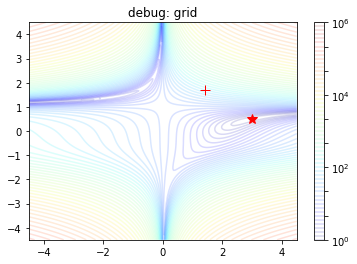

In [29]:
ax = plt.gca()
cm=ax.contour(x, y, z - z_min[0] + zeps, levels=np.logspace(0, logzmax//2, 55), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('debug: grid')

plt.show()

# Run

In [31]:
import torch.optim as optim
lr = problem.lr
constructors = dict(
    # need smaller lr's sometimes
    SGD= lambda params: optim.SGD(params, lr=lr),
    momentum = lambda params: optim.SGD(params, lr=lr, momentum=0.9),
    nesterov = lambda params: optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
    nesterov_decay = lambda params: optim.SGD(params, lr=lr, momentum=0.9, nesterov=True, weight_decay=1e-4),
    
    # need larger lr's sometimes
    Adadelta = lambda params: optim.Adadelta(params),
    Adagrad = lambda params: optim.Adagrad(params, lr=lr),
    
    # 
    Adamax = lambda params: optim.Adamax(params, lr=lr),
    RMSprop = lambda params: optim.RMSprop(params, lr=lr),
    Adam = lambda params: optim.Adam(params, lr=lr),
    #     lambda params:  optim.Adam(params, lr=lr, weight_decay=1e-2),
    
    # need to read about these, might not be comparable
#     ASGD = lambda params: optim.ASGD(params, lr=lr),
#     Rprop = lambda params: optim.Rprop(params, lr=lr),
#     LBFGS = lambda params: optim.LBFGS(params),
)

In [32]:
results = {}
distance = {}

for name, constructor in constructors.items():
    data, dist = test_f(problem.f, problem.df, constructor, x0=problem.x0, steps=problem.steps)
    results[name] = data
    distance[name] = dist

In [35]:
# calc paths and elevation
methods = constructors.keys()
paths = np.array([path.T for path in results.values()]) # should be (2,N) each
zpaths = np.array([[problem.f(torch.FloatTensor(p)).numpy()-z_min[0] + zeps for p in path.T] for path in paths])
paths.shape, zpaths.shape

((9, 2, 6000), (9, 6000, 1))

In [36]:
# DEBUG: check z's
for i, name in enumerate(results):
    zmax = zpaths[i][np.isfinite(zpaths[i])].max()
    print(name, zmax, np.isfinite(zmax).all())

SGD 47.4099 True
momentum 47.4099 True
nesterov 25.8805 True
nesterov_decay 25.8805 True
Adadelta 95.8278 True
Adagrad 96.548 True
Adamax 96.548 True
RMSprop 93.5872 True
Adam 96.548 True


In [37]:
# clip zpaths
zmax = z.max()
zpaths[np.isfinite(zpaths)==False]=zmax
zpaths = np.clip(zpaths, 0, zmax)

# Preview plots

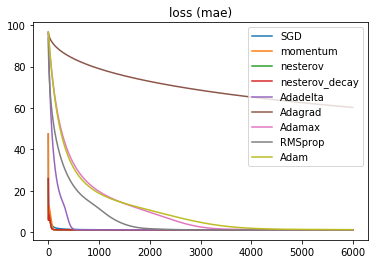

In [38]:
for i, name in enumerate(results):
    plt.plot(np.abs(zpaths[i]), label=name)
plt.legend()
plt.title('loss (mae)')

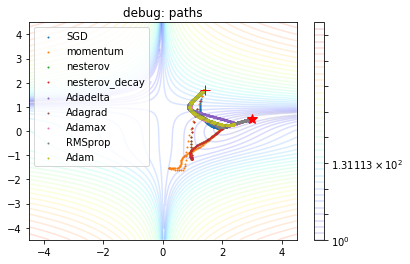

In [40]:
# static preview 2d to let you debug your steps and learning rate
ax = plt.gca()
for name in results:
    plt.scatter(*results[name].T, label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

cm=ax.contour(x, y, z - z_min[0] + zeps, levels=np.logspace(0, logzmax//2, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('debug: paths')

plt.show()

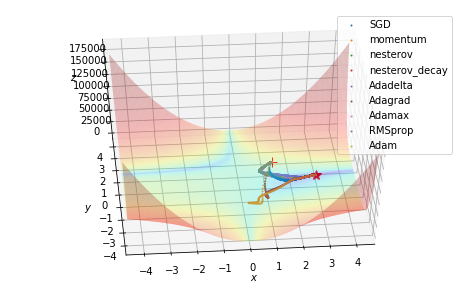

In [39]:
# static preview 3d
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=azim)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.25, cmap=plt.cm.jet)
ax.plot(*minima_, problem.f(minima_).numpy(), 'r*', markersize=10)
ax.plot(*_x0, problem.f(_x0).numpy(), 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

# anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)
# quick plot to let you debug your steps and learning rate
ax = plt.gca()
for i, name in enumerate(results):
    ax.scatter3D(*results[name].T, zpaths[i], label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax.legend(loc='top right')

# Animation

In [41]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [42]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

# 2d anim

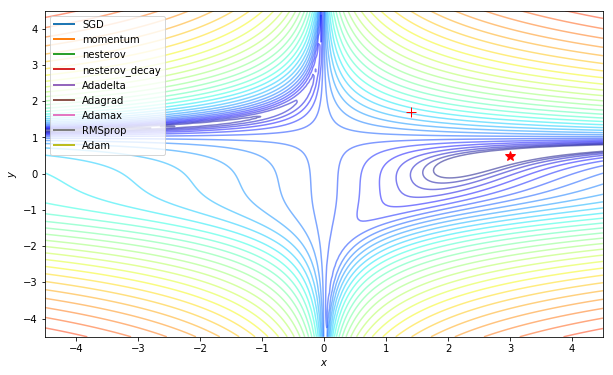

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.5)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [47]:
# anim.to_html5_video()
save_file = 'videos/{name:}_{ts:}.m4v'.format(name=problem.f.__name__, ts=ts)
print(save_file)
anim.save(save_file)

# display
html="""<video {options}>
  <source type="video/mp4" src="{video}">
  Your browser does not support the video tag.
</video>""".format(options=' '.join(['controls', 'autoplay']), video=save_file)
print(html)
HTML(html)

videos/beales_20171115_07-18-03.m4v
<video controls autoplay>
  <source type="video/mp4" src="videos/beales_20171115_07-18-03.m4v">
  Your browser does not support the video tag.
</video>


# 3d anim

-100

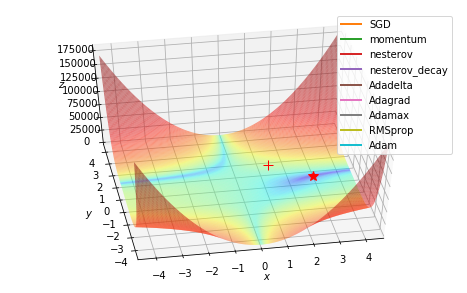

In [70]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=azim)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.5, cmap=plt.cm.jet)
ax.plot(*minima_, problem.f(minima_).numpy(), 'r*', markersize=10)
ax.plot(*_x0, problem.f(_x0).numpy(), 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths[:,:,0], labels=methods, ax=ax)

ax.legend(loc='upper right')

In [ ]:
# anim.to_html5_video()
save_file3d = save_file.replace('.m4v', '_3d.m4v')
print(save_file3d)

anim.save(save_file3d)

# display
html="""<video {options}>
  <source type="video/mp4" src="{video}">
  Your browser does not support the video tag.
</video>""".format(options=' '.join(['controls', 'autoplay']), video=save_file3d)
print(html)
HTML(html)

videos/beales_20171115_07-18-03_3d.m4v


# loss anim

same as 2d but instead of x,y it's steps,np.abs(z-zmin)

In [ ]:
index = np.arange(1,problem.steps+1,1)[None,:]
index= np.array([index]*zpaths.shape[0])
loss_paths = np.concatenate([index, zpaths[:,None,:,0]], 1)
loss_paths.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((0, loss_paths[:,0,:].max()))
ax.set_ylim((0, loss_paths[:,1,:].max()))

anim = TrajectoryAnimation(*loss_paths, labels=methods, ax=ax)

ax.legend(loc='upper right')

In [ ]:
# anim.to_html5_video()
save_file_loss = save_file.replace('.m4v', '_loss.m4v')
print(save_file_loss)
anim.save(save_file_loss)

# display
html="""<video {options}>
  <source type="video/mp4" src="{video}">
  Your browser does not support the video tag.
</video>""".format(options=' '.join(['controls', 'autoplay']), video=save_file_loss)
print(html)
HTML(html)